In [ ]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, json, datetime, time, shutil
import numpy as np

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

# LETKF for observation with all moorings

## Set up ensemble from file 
1. Parameters
2. Input files
3. UDF packages + UDF plotting functions
4. ensemble initialization


In [ ]:
#--------------------------------------------------------------
# PARAMETERS
#--------------------------------------------------------------
args_ensemble_size = 100
args_method = "ETKF" 
args_observation_interval = 1
args_observation_variance = 1.0
args_observation_type = "buoys"
args_buoy_area = "all"
args_media_dir = "forecasting_results/"

args_num_days = 7
args_num_hours = 24
args_forecast_days = 3
args_profiling = False


# Checking input args
if args_ensemble_size is None:
    print("Ensemble size missing, please provide a --ensemble_size argument.")
    sys.exit(-1)
elif args_ensemble_size < 1:
    parser.error("Illegal ensemble size " + str(args.ensemble_size))

profiling = args_profiling


In [ ]:
###-----------------------------------------
## Define files for ensemble and truth.
##

#ensemble_init_path = 'C:/Users/florianb/Documents/GPU-Ocean/gpu-ocean/data/ensemble_init/'
#ensemble_init_path = '/home/florianb/gpu-ocean/data/ensemble_init/'
ensemble_init_path = '../../../data/ensemble_init/'
assert len(os.listdir(ensemble_init_path)) == 100 or len(os.listdir(ensemble_init_path)) == 101, \
    "Ensemble init folder has wrong number of files: " + str(len(os.listdir(ensemble_init_path)))

#truth_path = 'C:/Users/florianb/Documents/GPU-Ocean/gpu-ocean/data/true_state/'
#truth_path = '/home/florianb/gpu-ocean/data/true_state/'
truth_path = '../../../data/true_state/'
assert len(os.listdir(truth_path)) == 2 or len(os.listdir(truth_path)) == 3, \
    "Truth folder has wrong number of files"


timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
media_dir = args_media_dir
destination_dir = os.path.join(media_dir, "da_experiment_" +  timestamp + "/")
os.makedirs(destination_dir)

# Copy the truth into the destination folder
shutil.copytree(truth_path, os.path.join(destination_dir, 'truth'))

# Define misc filenames
log_file = os.path.join(destination_dir, 'description.txt')

particleInfoPrefix = os.path.join(destination_dir, 'particle_info_')
forecastFileBase = os.path.join(destination_dir, 'forecast_member_')


with open(log_file, 'w') as f:
    f.write('Data Assimilation experiment ' + timestamp + '\n')
    f.write('----------------------------------------------' + '\n')

def logParams():
    log('Input arguments:')
    #for arg in vars(args):
    #    log('\t' + str((arg, getattr(args, arg))))
    log('\nPath to initial conditions for ensemble:')
    log('\t' + ensemble_init_path)
    log('Path to true state:')
    log('\t' + truth_path)
    log('destination folder:')
    log('\t' + destination_dir)
    log('Path to particle info:')
    log('\t' + particleInfoPrefix)
    log('Path to forecast members:')
    log('\t' + forecastFileBase)

def log(msg, screen=True):
    with open(log_file, 'a') as f:
        f.write(msg + '\n')
    if screen:
        print(msg)
        
logParams()
        
    
# Reading and checking method
method = str(args_method).lower()
if method == 'iewpf2':
    log(' ----> Using IEWPF 2 stage method')
elif method == 'enkf':
    log(' ----> Using EnKF')
elif method == 'etkf':
    log(' ----> Using ETKF')
elif method == 'none':
    log(' ----> No data assimilation')
else:
    log('Illegal method: ' + str(method))
    sys.exit(-1)
    
    
# Time parameters
start_time      =  3*24*60*60 #  3 days in seconds
simulation_time = 10*24*60*60 # 10 days in seconds (three days spin up is prior to this)fa
end_time        = 13*24*60*60 # 13 days in seconds


# Based on truth from June 25th 2019
#drifterSet = [ 2, 7, 12, 24, 29, 35, 41, 48, 53, 60]
drifterSet = [ 2, 24, 60]

# Log extra information for the ensemble state for the following cells:
extraCells = np.array([[254, 241], # Cross with two trajectories
                       [249, 246], # northwest of above
                       [259, 236], # southeast of above
                       [343, 131], # Closed circle of same drifter
                       [196,  245], # Middle of single trajectory
                       [150,  250], # Middle of single trajectory, later than above
                       [102, 252], # On the same trajectory as the above, but later, and also in a intersection
                       [ 388, 100], # Unobserved area just north of southern jet
                       [ 388, 80],  # Unobserved area in southern jet
                       [ 388, 150], # Unobserved area in calm area
                      ])

Input arguments:

Path to initial conditions for ensemble:
	../../../data/ensemble_init/
Path to true state:
	../../../data/true_state/
destination folder:
	forecasting_results/da_experiment_2021_01_25-13_05_44/
Path to particle info:
	forecasting_results/da_experiment_2021_01_25-13_05_44/particle_info_
Path to forecast members:
	forecasting_results/da_experiment_2021_01_25-13_05_44/forecast_member_
 ----> Using ETKF


In [ ]:
###--------------------------------
# Import required packages
#
tic = time.time()
# For GPU contex:
from SWESimulators import Common
# For the ensemble:
from SWESimulators import EnsembleFromFiles, Observation
# For data assimilation:
from SWESimulators import IEWPFOcean
import ETKFOcean
# For forcasting:
from SWESimulators import GPUDrifterCollection
# For ObservationType:
from SWESimulators import DataAssimilationUtils as dautils

toc = time.time()
log("\n{:02.4f} s: ".format(toc-tic) + 'GPU Ocean packages imported', True)

# Create CUDA context
tic = time.time()
gpu_ctx = Common.CUDAContext()
device_name = gpu_ctx.cuda_device.name()
toc = time.time()
log("{:02.4f} s: ".format(toc-tic) + "Created context on " + device_name, True)


0.0000 s: GPU Ocean packages imported
0.1080 s: Created context on Quadro T2000


In [ ]:
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), # (12.5, 3.4)
            color_bar_from_zero=False, save_filename=None, constant_range=False, pretitle='',
            mark_drifter_positions = None):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    #fig = plt.figure(figsize=figsize)

    #gs = fig.add_gridspec(1,10)#, sharey=True)
    #axs = [None, None, None]
    #axs[0] = fig.add_subplot(gs[0, 1:4])
    #axs[1] = fig.add_subplot(gs[0, 4:7])
    #axs[2] = fig.add_subplot(gs[0, 7:10])
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 3.5
        huv_max = 625
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.12
            huv_max = 50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
        
    nx = ensemble.nx
    ny = ensemble.ny
    dx = ensemble.dx
    dy = ensemble.dy
    extent=np.array([0, nx*dx, 0, ny*dy]) / 1000
    
    
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")
    
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[2], hv_im, pretitle+"$hv$ [m$^2$/s]")
    
    #axs[0].set_ylabel(main_title, labelpad=3, fontsize=fontsize)

    if mark_drifter_positions is not None:
        _markDriftersInImshow(axs[1], mark_drifter_positions)
        _markDriftersInImshow(axs[2], mark_drifter_positions)
    
    #for ax in axs:
    #    ax.set_xlabel("$x$ [km]")
    #    ax.set_ylabel("$y$ [km]")
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    #plt.tight_layout()
    
    if save_filename is not None and savefigs:
        fig.savefig(result_dir + "/" + save_filename + ".png", bbox_inches='tight')
        fig.savefig(result_dir + "/" + save_filename + ".pdf", bbox_inches='tight')
        
        

In [ ]:
###--------------------------
# Initiate the ensemble
#

observation_type = dautils.ObservationType.UnderlyingFlow
if args_observation_type == 'buoys':
    observation_type = dautils.ObservationType.StaticBuoys
    log('Observation type changed to StaticBuoys!')
elif args_observation_type == 'all_drifters':
    drifterSet = 'all'
    log('Using all drifters for DA experiment')

print(observation_type)

cont_write_netcdf = True and not profiling

tic = time.time()
ensemble = EnsembleFromFiles.EnsembleFromFiles(gpu_ctx, args_ensemble_size, \
                                               ensemble_init_path, truth_path, \
                                               args_observation_variance,
                                               cont_write_netcdf = cont_write_netcdf,
                                               use_lcg = True,
                                               write_netcdf_directory = destination_dir,
                                               observation_type=observation_type)

# Configure observations according to the selected drifters:
ensemble.configureObservations(drifterSet=drifterSet, 
                               observationInterval = args_observation_interval,
                               buoy_area = args_buoy_area)
ensemble.configureParticleInfos(extraCells)
toc = time.time()
log("{:02.4f} s: ".format(toc-tic) + "Ensemble is loaded and created", True)
log("Using drifterSet:\n" + str(drifterSet))
if args_observation_type == 'buoys':
    log('buoys to read:')
    log(str(ensemble.observations.read_buoy))


dt_ref = ensemble.particles[-1].dt

Observation type changed to StaticBuoys!
4
10.0730 s: Ensemble is loaded and created
Using drifterSet:
[2, 24, 60]
buoys to read:
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,

## Data Assimilaion Initialisation 


In [ ]:
### -------------------------------
# Initialize DA class (if needed)
#
tic = time.time()
iewpf = None
if method.startswith('iewpf'):
    iewpf = IEWPFOcean.IEWPFOcean(ensemble)
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Data assimilation class IEWPFOcean initiated", True)
elif method.startswith('enkf'):
    enkf = EnKFOcean.EnKFOcean(ensemble)
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Data assimilation class EnKFOcean initiated", True)
elif method.startswith('etkf'):
    etkf = ETKFOcean.ETKFOcean(ensemble)
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Data assimilation class ETKFOcean initiated", True)
else:
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Skipping creation of a DA class", True)

    


Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0000.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0001.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0002.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0003.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0004.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0005.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0006.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0007.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0008.nc ...
Closing file forecasting_results/da_experiment_2021_01_25-13_02_27/ensemble_member_0009.nc ...
Closing file forecasting_results/da_experiment_202

## Utility Functions for the Localisation Stencil

Functions:
1. getLocalIndices
2. distGC
3. getLocalWeightShape
4. getCombinedWeights 

Input:
- r_factor (master parameter for the previous scale_r, blocked_r, scale_slope)
- dx, dy, nx, ny from the simulator
- drifter_positions

PreProcessing Values:
- W_loc
- W_forecast (global)
- W_analysis (global)



In [ ]:
### ----------------------------------------------
#   PRE PROCESSING
#

In [ ]:
def getLocalIndices(obs_loc, scale_r, dx, dy, nx, ny):
    """ 
    Defines mapping from global domain (nx times ny) to local domain
    """
    #TODO: Serious ghost cell handling!

    boxed_r = dx*scale_r*2
    
    localIndices = np.array([[False]*nx]*ny)
    
    obs_loc_cellID = (np.int(obs_loc[0]//dx), np.int(obs_loc[1]//dy))

    #print(obs_loc_cellID)
    loc_cell_left  = np.int((obs_loc[0]-boxed_r   )//dx)
    loc_cell_right = np.int((obs_loc[0]+boxed_r+dx)//dx)
    loc_cell_down  = np.int((obs_loc[1]-boxed_r   )//dy)
    loc_cell_up    = np.int((obs_loc[1]+boxed_r+dy)//dy)

    xranges = []
    yranges = []
    
    xroll = 0
    yroll = 0

    if loc_cell_left < 0:
        xranges.append((nx+loc_cell_left , nx))
        xroll = loc_cell_left   # negative number
        loc_cell_left = 0 
    elif loc_cell_right > nx:
        xranges.append((0, loc_cell_right - nx))
        xroll = loc_cell_right - nx   # positive number
        loc_cell_right = nx 
    xranges.append((loc_cell_left, loc_cell_right))

    if loc_cell_down < 0:
        yranges.append((ny+loc_cell_down , ny))
        yroll = loc_cell_down   # negative number
        loc_cell_down = 0 
    elif loc_cell_up > ny:
        yranges.append((0, loc_cell_up - ny ))
        yroll = loc_cell_up - ny   # positive number
        loc_cell_up = ny
    yranges.append((loc_cell_down, loc_cell_up))


    # print(nx, ny)
    # print(loc_cell_left, loc_cell_right, loc_cell_down, loc_cell_up)
    # print(xranges)
    # print(yranges)

    #print(localIndices.shape)

    for xrange in xranges:
        for yrange in yranges:
            localIndices[yrange[0] : yrange[1], xrange[0] : xrange[1]] = True

            for y in range(yrange[0],yrange[1]):
                for x in range(xrange[0], xrange[1]):
                    loc = np.array([(x+0.5)*dx, (y+0.5)*dy])

    return localIndices, xroll, yroll
        



In [ ]:
def distGC( obs, loc, r, lx, ly):
    """
    Calculating the Gasparin-Cohn value for the distance between obs 
    and loc for the localisation radius r.
    
    obs: drifter positions ([x,y])
    loc: current physical location to check (either [x,y] or [[x1,y1],...,[xd,yd]])
    r: localisation scale in the Gasparin Cohn function
    lx: domain extension in x-direction (necessary for periodic boundary conditions)
    ly: domain extension in y-direction (necessary for periodic boundary conditions)
    """
    if not obs.shape == loc.shape: 
        obs = np.tile(obs, (loc.shape[0],1))
    
    if len(loc.shape) == 1:
        dist = min(np.linalg.norm(np.abs(obs-loc)),
                np.linalg.norm(np.abs(obs-loc) - np.array([lx,0 ])),
                np.linalg.norm(np.abs(obs-loc) - np.array([0 ,ly])),
                np.linalg.norm(np.abs(obs-loc) - np.array([lx,ly])) )
    else:
        dist = np.linalg.norm(obs-loc, axis=1)

    # scalar case
    if isinstance(dist, float):
        distGC = 0.0
        if dist/r < 1: 
            distGC = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
        elif dist/r >= 1 and dist/r < 2:
            distGC = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))
    # vector case
    else:
        distGC = np.zeros_like(dist)
        for i in range(len(dist)):
            if dist[i]/r < 1: 
                distGC[i] = 1 - 5/3*(dist[i]/r)**2 + 5/8*(dist[i]/r)**3 + 1/2*(dist[i]/r)**4 - 1/4*(dist[i]/r)**5
            elif dist[i]/r >= 1 and dist[i]/r < 2:
                distGC[i] = 4 - 5*(dist[i]/r) + 5/3*(dist[i]/r)**2 + 5/8*(dist[i]/r)**3 -1/2*(dist[i]/r)**4 + 1/12*(dist[i]/r)**5 - 2/(3*(dist[i]/r))

    return distGC


def getLocalWeightShape(scale_r, dx, dy, nx, ny):
    
    local_nx = int(scale_r*2*2)+1
    local_ny = int(scale_r*2*2)+1
    weights = np.zeros((local_ny, local_ny))
    
    obs_loc_cellID = (local_ny, local_nx)
    obs_loc = np.array([local_nx*dx/2, local_ny*dy/2])
    #print(obs_loc)
    #print(obs_loc[0]/dx, obs_loc[1]/dy)

    for y in range(local_ny):
        for x in range(local_nx):
            loc = np.array([(x+0.5)*dx, (y+0.5)*dy])
            weights[y,x] = min(1, distGC(obs_loc, loc, scale_r*dx, nx*dx, ny*dy))
                        
        
    return weights
        



In [ ]:
def getCombinedWeights(observation_positions, scale_r, dx, dy, nx, ny):
    
    W_scale = np.zeros((ny, nx))
    
    num_drifters = observation_positions.shape[0]
    #print('found num_drifters:', num_drifters)
    if observation_positions.shape[1] != 2:
        print('observation_positions has wrong shape')
        return None

    # Get the shape of the local weights (drifter independent)
    W_loc = getLocalWeightShape(scale_r, dx, dy, nx, ny)
    
    for d in range(num_drifters):
        # Get local mapping for drifter 
        L, xroll, yroll = getLocalIndices(observation_positions[d,:], scale_r, dx, dy, nx, ny)

        # Roll weigths according to periodic boundaries
        W_loc_d = np.roll(np.roll(W_loc, shift=yroll, axis=0 ), shift=xroll, axis=1)
        
        # Add weights to global domain based on local mapping:
        W_scale[L] += W_loc_d.flatten()

        
    return W_scale

### 1. Set-up Parameters

In [ ]:
# Parameters:
r_factor = 10

ghost_cells_x = 2
ghost_cells_y = 2

dx = ensemble.dx
dy = ensemble.dy
nx = ensemble.nx
ny = ensemble.ny

# Drifter positions of Observations
drifter_positions = ensemble.observeTrueDrifters()

### 2. W_loc 


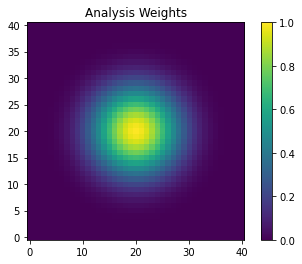

In [ ]:
W_loc = getLocalWeightShape(r_factor, dx, dy, nx, ny)

plt.imshow(W_loc, origin='lower')
plt.title("Analysis Weights")
plt.colorbar()
plt.show()


### 3. W_analysis and W_forecast

For only 2 observation points (a single observation requires technical changes in getCombinedWeights, but I deleted my change since it was very dirty)

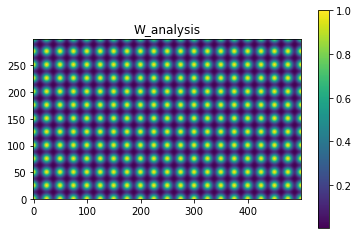

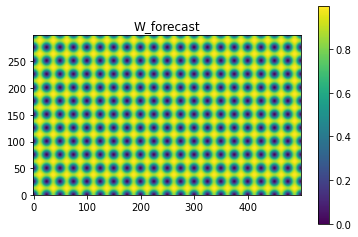

Wall time: 4.17 s


In [ ]:
%%time
#DEBUG: Only one row of observations
W_combined = getCombinedWeights(drifter_positions, r_factor, ensemble.dx, ensemble.dy, ensemble.nx, ensemble.ny)

W_scale = np.maximum(W_combined, 1)

W_analysis = W_combined/W_scale

W_forecast = np.ones_like(W_scale) - W_analysis

plt.imshow(W_analysis, origin='lower')
plt.title("W_analysis")
plt.colorbar()
plt.show()

plt.imshow(W_forecast, origin='lower')
plt.title("W_forecast")
plt.colorbar()
plt.show()


## Data Assimilation with Håvards LETKF


In [ ]:
### ----------------------------------------------
#   DATA ASSIMILATION
#

obstime = start_time # time in seconds (starting after spin-up phase)

master_tic = time.time()

numDays = args_num_days 
numHours = args_num_hours 
forecast_days = args_forecast_days


log('---------- Starting simulation --------------') 
log('--- numDays:       ' + str(numDays))
log('--- numHours:      ' + str(numHours))
log('--- forecast_days: ' + str(forecast_days))
log('---------------------------------------------') 


drifter_cells = ensemble.getDrifterCells()

ensemble.stepToObservation(start_time+5*60)

---------- Starting simulation --------------
--- numDays:       7
--- numHours:      24
--- forecast_days: 3
---------------------------------------------


### Quick book-keeping which is usually done in the class

In [ ]:
N_e = ensemble.getNumParticles()
N_e_active = ensemble.getNumActiveParticles()

### Generate $X_f$ from the ensemble

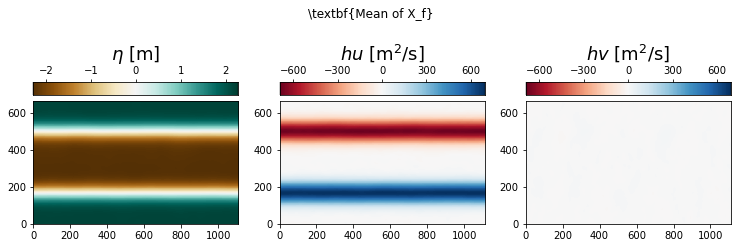

In [ ]:
# Global forecasts 
def giveX_f_global(ensemble):

    X_f = np.zeros((N_e_active,3,ny,nx))

    idx = 0
    for e in range(N_e):
        if ensemble.particlesActive[e]:
            eta, hu, hv = ensemble.particles[e].download(interior_domain_only=True)
            X_f[idx,0,:,:] = eta 
            X_f[idx,1,:,:] = hu
            X_f[idx,2,:,:] = hv
            idx += 1

    X_f_mean = 1/N_e_active * np.sum(X_f,axis=0)

    X_f_pert = np.zeros_like( X_f )
    for e in range(N_e_active):
        X_f_pert[e,:,:,:] = X_f[e,:,:,:] - X_f_mean

    return X_f, X_f_mean, X_f_pert


X_f, X_f_mean, X_f_pert = giveX_f_global(ensemble)

imshow3(X_f_mean[0], X_f_mean[1], X_f_mean[2], title="Mean of X_f")

In [ ]:
# Global observations
def giveHX_f_global(ensemble):

    HX_f = ensemble.observeParticles()

    HX_f_mean = 1/N_e_active * np.sum(HX_f, axis=0)

    HX_f_pert = HX_f - HX_f_mean

    return HX_f_mean, HX_f_pert


HX_f_mean, HX_f_pert = giveHX_f_global(ensemble)

### Preparing $X_a$

In [ ]:
X_a = np.zeros_like(X_f)

## Roll and weight for only the first observation position!!! 

Thats the tricky part with a bug :(

In [ ]:
%%time
for d in range(drifter_positions.shape[0]):
    # Collecting rolling information (xroll and yroll are 0)
    L, xroll, yroll = getLocalIndices(drifter_positions[d,:], r_factor, dx, dy, nx, ny)
    N_x_local = np.sum(L)

    # LOCAL ARRAY FOR FORECAST (basically extracting local values from global array)
    X_f_loc_tmp = np.zeros((N_e_active, 3, N_x_local))
    X_f_loc_pert_tmp = np.zeros((N_e_active, 3, N_x_local))
    X_f_loc_mean_tmp = np.zeros((3, N_x_local))
    for e in range(N_e_active):
        for i in range(3):
            X_f_loc_tmp[e,i,:] = X_f[e,i,L]
            X_f_loc_pert_tmp[e,i,:] = X_f_pert[e,i,L]
    for i in range(3):
        X_f_loc_mean_tmp[i,:] = X_f_mean[i,L]

    # Roll local array (this should not change anything here!)
    for e in range(N_e_active):
        # for eta, hu,
        for i in range(3): 
            # roll the local domain so that it does not go through the boundaries
            X_f_loc_tmp[e,i,:] = np.roll(np.roll(X_f_loc_tmp[e,i,:].reshape(W_loc.shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1).flatten()
            X_f_loc_pert_tmp[e,i,:] = np.roll(np.roll(X_f_loc_pert_tmp[e,i,:].reshape(W_loc.shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1).flatten()
    for i in range(3): 
        # roll the local domain so that it does not go through the boundaries
        X_f_loc_mean_tmp[i,:] = np.roll(np.roll(X_f_loc_mean_tmp[i,:].reshape(W_loc.shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1).flatten()

    # FROM LOCAL ARRAY TO LOCAL VECTOR FOR FORECAST (we concatinate eta, hu and hv components)
    X_f_loc = np.zeros((3*N_x_local, N_e_active))
    X_f_loc_pert = np.zeros((3*N_x_local, N_e_active))
    X_f_loc_mean = np.append(X_f_loc_mean_tmp[0,:],np.append(X_f_loc_mean_tmp[1,:],X_f_loc_mean_tmp[2,:]))
    for e in range(N_e_active):
        X_f_loc[:,e] = np.append(X_f_loc_tmp[e,0,:],np.append(X_f_loc_tmp[e,1,:],X_f_loc_tmp[e,2,:]))
        X_f_loc_pert[:,e] = np.append(X_f_loc_pert_tmp[e,0,:],np.append(X_f_loc_pert_tmp[e,1,:],X_f_loc_pert_tmp[e,2,:]))

    # Local observations
    HX_f_loc_mean = HX_f_mean[d,:]
    HX_f_loc_pert = HX_f_pert[:,d,:].T

    ############LETKF

    # Rinv 
    Rinv = np.linalg.inv(ensemble.getObservationCov())

    # D
    y_loc = ensemble.observeTrueState()[d,2:4].T
    D = y_loc - HX_f_loc_mean

    # P 
    A1 = (N_e_active-1) * np.eye(N_e_active)
    A2 = np.dot(HX_f_loc_pert.T, np.dot(Rinv, HX_f_loc_pert))
    A = A1 + A2

    P = np.linalg.inv(A)

    # K 
    K = np.dot(X_f_loc_pert, np.dot(P, np.dot(HX_f_loc_pert.T, Rinv)))

    # local analysis
    X_a_loc_mean = X_f_loc_mean + np.dot(K, D)

    sigma, V = np.linalg.eigh( (N_e_active-1) * P )
    X_a_loc_pert = np.dot( X_f_loc_pert, np.dot( V, np.dot( np.diag( np.sqrt( np.real(sigma) ) ), V.T )))

    X_a_loc = X_a_loc_pert 
    for j in range(N_e_active):
        X_a_loc[:,j] += X_a_loc_mean

    
    # FROM LOCAL VECTOR TO GLOBAL ARRAY (we fill the global X_a with the *weighted* local values)
    for e in range(N_e_active):
        W_analysis_loc = np.roll(np.roll(W_analysis[L].reshape(W_loc.shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1).flatten()
        # eta, hu, hv
        for i in range(3):
            # Calculate weighted local analysis
            weighted_X_a_loc = X_a_loc[i*N_x_local:(i+1)*N_x_local,e]*(W_analysis_loc.flatten())
            # Roll the local domain back according to periodic boundaries again (nothing should happen here)
            weighted_X_a_loc = np.roll(np.roll(weighted_X_a_loc.reshape(W_loc.shape), shift=yroll, axis=0 ), shift=xroll, axis=1)
            # Add to global X_a
            X_a[e,i,L] += weighted_X_a_loc.flatten()

# COMBINING (the already weighted) ANALYSIS WITH THE FORECAST
X_new = np.zeros_like(X_f)
for e in range(N_e_active):
    for i in range(3):
        X_new[e][i] = W_forecast*X_f[e][i] + X_a[e][i]



Wall time: 2min 6s


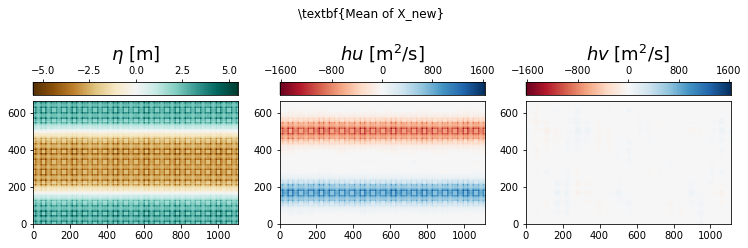

In [ ]:
X_new_mean = 1/N_e_active * np.sum(X_new, axis=0)

imshow3(X_new_mean[0], X_new_mean[1], X_new_mean[2], title="Mean of X_new")